# Introduction

This notebook contains an implementation of the quantum algorithm introduced by Niedermeier et al. (https://doi.org/10.1103/PhysRevResearch.6.043288) for calculating the Chern number of a system. The implementation is performed using the (noiseless) quantum simulators provided by IBM with the Qiskit library.

# Hadamard Phase Estimator #

Implement Hadamard algorithm for estimating phase imprinted by a unitary gate $U$ on a state $|\psi\rangle$:
$$
U|\psi\rangle = e^{i\theta}|\psi\rangle
$$

### Circuit Diagram ###

In [356]:
# Imports
import numpy as np
import scipy as sp
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import AerSimulator
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display


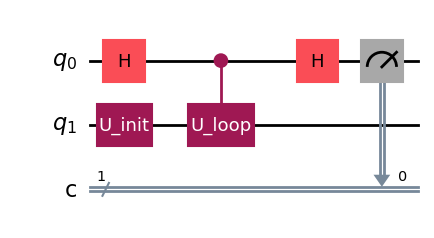

In [ ]:
def C_circuit(U, U_init=None):
    qc = QuantumCircuit(2,1)
    if U_init is not None:
        u_init_gate = UnitaryGate(U_init, label="U_init")
        qc.append(u_init_gate, [1])
    qc.h(0)
    u_gate = UnitaryGate(U, label="U_loop")
    cu_gate = u_gate.control()
    qc.append(cu_gate, [0,1])
    qc.h(0)
    qc.measure(0,0)
    return qc

U = np.array([[1, 0],
              [0, np.exp(1j * np.pi/4)]])
qc = C_circuit(U)
qc.draw('mpl')

The classical bit reads 0 with probability $P(0) = \frac{1}{2}(1+\cos(\theta))$, so $\cos(\theta)=2P(0)-1$. Alternatively, can measure $\sin(\theta)$ by also incorporating an $S$-gate ($Z_{90}$ gate):

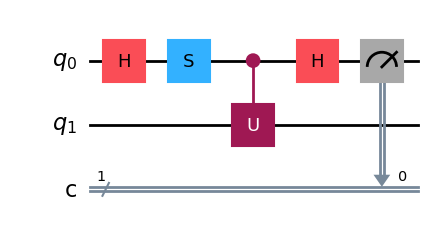

In [324]:
def S_circuit(U, U_init=None):
    qc = QuantumCircuit(2,1)
    if U_init is not None:
        u_init_gate = UnitaryGate(U_init, label="U_init")
        qc.append(u_init_gate, [1])
    qc.h(0)
    qc.s(0)
    u_gate = UnitaryGate(U, label="U")
    cu_gate = u_gate.control()
    qc.append(cu_gate, [0,1])
    qc.h(0)
    qc.measure(0,0)
    return qc

qc = S_circuit(U)
qc.draw('mpl')

This allows the determination of $\sin(\theta)=1-2P(0)$. Of course, in both cases, multiple shots are required to accurately estimate the probability $P(0)$. This is implemented by the following code. There is also the procedure for determining which of $\arccos$ or $\arcsin$ should be used for the inverse, depending on the signs of the $\cos$ and $\sin$ results.

### Implementation and Testing

In [326]:
def estimate_cos(U, U_init=None, backend=AerSimulator(), shots=1024):
    qc = C_circuit(U, U_init=U_init)
    transpiled_qc = transpile(qc, backend=backend, optimization_level=1)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    P0 = counts.get('0', 0) / shots
    return 2*P0 - 1


def estimate_sin(U, U_init=None, backend=AerSimulator(), shots=1024):
    qc = S_circuit(U, U_init=U_init)
    transpiled_qc = transpile(qc, backend=backend, optimization_level=1)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    P0 = counts.get('0', 0) / shots
    return 1 - 2*P0


def estimate_theta(U, U_init=None, backend=AerSimulator(), shots=1024):
    c = estimate_cos(U, U_init=U_init, backend=backend, shots=shots)
    s = estimate_sin(U, U_init=U_init,  backend=backend, shots=shots)
    if s < 0:
        if c < 0:
            t = -np.pi + np.abs(np.arcsin(s))
        else:
            t = np.arcsin(s)
    else:
        t = np.arccos(c)
    return t


t = (2*np.pi*np.random.rand(1)[0] - np.pi)
print('Randomly generated theta = ' + str(np.round(t, 4)))

U_t = np.array([[np.exp(1j*t), 0],
                [0, 1]])

shots = 8192
t_est = estimate_theta(U=U_t, backend=AerSimulator(), shots=shots)
dt = 1 / np.sqrt(shots)
print('Shots = ' + str(shots))
print('Estimated theta = ' + str(np.round(t_est, 4)))
print('Uncertainty = ' + str(np.round(dt, 4)))
print('Within error margin = ' + str(np.abs(t - t_est) < dt))

Randomly generated theta = 3.0808
Shots = 8192
Estimated theta = 3.0831
Uncertainty = 0.011
Within error margin = True


### Errors

The uncertainty in $\theta$ in fact only depends on the number of shots, $n$. With the counts of $c=0$ being $N(0)$, we have:
$$
N(0) = n P(0)\\[2ex]

\delta N = \sqrt{nP(1-P)}\\[2ex]

\delta P = \frac{\delta N}{n} = \sqrt{\frac{P(1-P)}{n}} = \sqrt{\frac{\frac{1}{4}(1+\cos(\theta))(1-\cos(\theta))}{n}} = \frac{\sin(\theta)}{2n}\\[2ex]

\delta \cos(\theta) = \sin(\theta) \delta\theta = 2 \delta P\\[2ex]

\delta \theta = \frac{1}{\sqrt{n}}
$$
So for a sufficiently large $n$, we can measure $\theta$ to arbitrary precision. In the paper, the authors say that the Hadamard phase test is only suitable for small phases, but this is only true in the sense that each individual run only gives a single bit of precision. As shown here, for sufficiently many shots, the Hadamard test is perfectly suitable to measure $\theta$ to any precision.

# QWZ Model

For simplicity, first implement the QWZ Model. Hamiltonian:
$$ 
H = \sin(k_x)\sigma_x + \sin(k_y)\sigma_y + (u + \cos(k_x) + \cos(k_y))\sigma_z = \mathbf{d}(\mathbf{k})\cdot\boldsymbol{\sigma}
$$
This has eigenvalues $\pm|\mathbf{d}|$, with eigenvectors which are aligned with $\mp \hat{\mathbf{d}}$ respectively. 

With the sign conventions here, this has different topological phases:
$$
C = \begin{cases}
+1 \quad -2 < u < 0\\
-1 \quad 0 < u < 2\\
0 \quad \text{otherwise}
\end{cases}
$$
Testing Hamiltonian and eigenvectors:

In [ ]:
def d_QWZ(k, u):
    dx = np.sin(k[0])
    dy = np.sin(k[1])
    dz = u + np.cos(k[0]) + np.cos(k[1])
    d = np.array([np.sin(k[0]), np.sin(k[1]), u + np.cos(k[0]) + np.cos(k[1])])
    return d


def H_QWZ(k, u):
    dk = d_QWZ(k, u)
    H = np.array([[d[2], d[0] - 1j*d[1]],
                  [d[0] + 1j*d[1], -d[2]]])
    return H


## Testing Eigenvector ##
k = np.array([0.2, 0.1]) * np.pi
u = 0.5

d = d_QWZ(k, u)
d_hat = d / np.linalg.norm(d)
d_mag = np.linalg.norm(d)
theta = np.arccos(d_hat[2])
phi = np.arctan(d_hat[1]/d_hat[0])
v = np.array([np.sin(theta/2), -np.cos(theta/2)*np.exp(1j*phi)])
H = H_QWZ(k, u)
evals, evects = np.linalg.eigh(H)
# Fix gauge
phases = np.angle(evects[0,:])
evects *= np.exp(-1j*phases)
print('Numerical eigenvalues and eigenvectors:')
print(np.round(evals,4))
print(np.round(evects,4))
print('Analytical prediction for lowest eigenvalue and eigenvector:')
print(np.round(-d_mag,4))
print(np.round(v,4))

Numerical eigenvalues and eigenvectors:
[-2.3556  2.3556]
[[ 0.1424+0.j      0.9898+0.j    ]
 [-0.8761-0.4606j  0.126 +0.0663j]]
Analytical prediction for lowest eigenvalue and eigenvector:
-2.3556
[ 0.1424+0.j     -0.8761-0.4606j]


Compute Berry curvature using standard plaquette method and compare to theory:

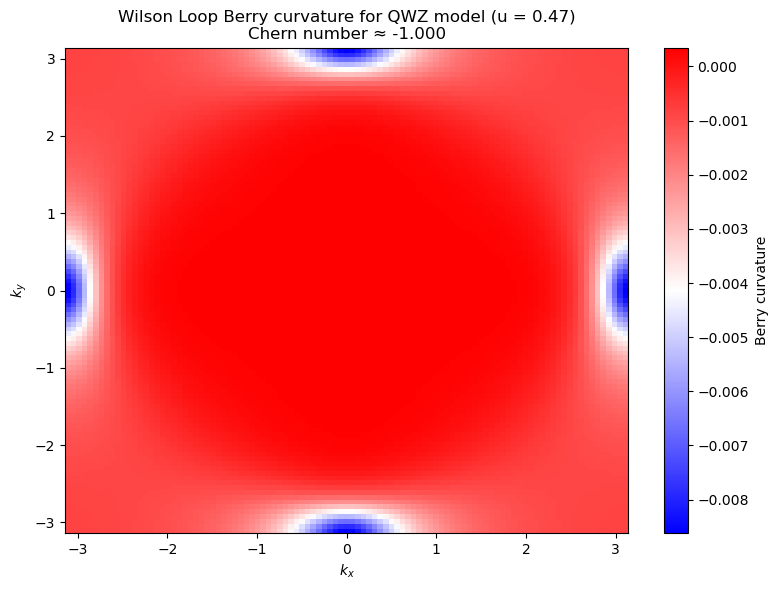

In [444]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

def hamiltonian_qwz(kx, ky, u):
    """Constructs the QWZ Hamiltonian H(kx, ky) = d · sigma"""
    dx = np.sin(kx)
    dy = np.sin(ky)
    dz = (u + np.cos(kx) + np.cos(ky))
    return dx * sigma_x + dy * sigma_y + dz * sigma_z

def gs_qwz(kx, ky, u, gauge=False):
    H = hamiltonian_qwz(kx, ky, u)
    _, vecs = np.linalg.eigh(H)
    v = vecs[:,0]
    if gauge:
        v *= np.exp(-1j*np.angle(v[0]))
    return v

def berry_flux(F00, F10, F11, F01):
    """Calculate the Berry flux through a plaquette"""
    U1 = np.vdot(F00, F10)
    U2 = np.vdot(F10, F11)
    U3 = np.vdot(F11, F01)
    U4 = np.vdot(F01, F00)
    return -np.angle(U1 * U2 * U3 * U4)      
    # NB, have included the minus sign here - not always done throughout the literature, but
    # gives consistent results with the definitions of the Berry connection/Berry phase etc.

def compute_berry_curvature_grid(u, N=101):
    kx_vals = np.linspace(-np.pi, np.pi, N+1)
    ky_vals = np.linspace(-np.pi, np.pi, N+1)
    dk = kx_vals[1] - kx_vals[0]

    # Compute wavefunctions
    wf = np.empty((N+1, N+1, 2), dtype=complex)
    for i, kx in enumerate(kx_vals):
        for j, ky in enumerate(ky_vals):
            # H = hamiltonian_qwz(kx, ky, u)
            # _, vecs = np.linalg.eigh(H)
            # wf[i, j] = vecs[:, 0]  # ground state
            wf[i, j] = gs_qwz(kx, ky, u)

    # Compute Berry curvature on each plaquette
    curvature = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            psi00 = wf[i, j]
            psi10 = wf[i + 1, j]
            psi11 = wf[i + 1, j + 1]
            psi01 = wf[i, j + 1]
            curvature[i, j] = berry_flux(psi00, psi10, psi11, psi01)

    chern = np.sum(curvature) / (2 * np.pi)

    # Grid for plotting
    KX, KY = np.meshgrid(kx_vals[:-1], ky_vals[:-1]) + dk/2
    return KX, KY, curvature, chern


def plot_curvature(KX, KY, F, chern, u, method='wilson', N_t=None, T=None, shots=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(KX, KY, F, shading='auto', cmap='bwr')
    fig.colorbar(c, ax=ax, label='Berry curvature')

    # # Draw BZ boundaries
    # for val in [-np.pi, np.pi]:
    #     ax.axhline(val, color='k', linestyle='--', lw=1)
    #     ax.axvline(val, color='k', linestyle='--', lw=1)
    if method == 'wilson':
        ax.set_title(f"Wilson Loop Berry curvature for QWZ model (u = {u})\nChern number ≈ {chern:.3f}")
    elif method == 'TE':
        ax.set_title(f"Time-Evolution Berry curvature for QWZ model\nu = {u}, N_t = {N_t}, T = {T}\nChern number ≈ {chern:.3f}")
    elif method == 'QPE':
        ax.set_title(f"Quantum Phase Estimation Berry curvature for QWZ model\nu = {u}, N_t = {N_t}, T = {T}, shots = {shots}\nChern number ≈ {chern:.3f}")
        
    ax.set_xlabel(r"$k_x$")
    ax.set_ylabel(r"$k_y$")
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    plt.tight_layout()
    plt.show()


# Compute and plot
u = 0.47  # Should be in topological phase
N = 101
KX, KY, F, chern = compute_berry_curvature_grid(u, N=N)
plot_curvature(KX, KY, F, chern, u, method='wilson')




# Time-Evolution

We therefore have a procedure for determining the phase associated with a unitary evolution $U$. To use this for calculating the Berry phase and Chern number, we want $U$ to be associated with the time evolution operator along a (small) loop in momentum space. This is approximated by a first-order Trotter expansion, where $U$ is broken up into a series of small time-steps:
$$
U(T,0) \approx \prod_{j=0}^{N-1} e^{-iH(\mathbf{k}(j\Delta t))\Delta t} \quad \Delta t = T / N
$$

### Time-Evolution Operator

The time-evolution operator (for constant $H$) is:
$$
U = e^{-iH\Delta t}
$$
(setting $\hbar=1$). Inserting the form of the Haldane Hamiltonian and expanding the exponential, we use the result $(\mathbf{d}\cdot\boldsymbol{\sigma})^2=\mathbb{I}|\mathbf{d}|^2$ to obtain:
$$
U = \mathbb{I}\cos(\theta) - i \hat{\mathbf{d}}\cdot\boldsymbol{\sigma}\sin(\theta)\\[2ex]
\theta = |\mathbf{d}|\Delta t
$$
This gives an explicit analytical expression for $U$ as a $2\times 2$ matrix as a function of $\mathbf{k}$. This is implemented in the code below, as well as an additional function which generates the total $U$-evolution for a square path starting from $\mathbf{k}_0$, with side-length $dk$. There are options for including a factor of $-1$ in the Hamiltonian, which corresponds to the reverse loop. Applying both $U_{\text{loop}}$ gates with positive and negative $H$ results in a cancellation of the dynamical phase, while an equal Berry phase is contributed in both cases.

### Testing Numerically for QWZ Model

Compute unitary $U$ matrices which propagate the eigenvector in time:

In [ ]:
def U_QWZ(k, dt, u, reverse=False):
    d = d_QWZ(k, u)
    if reverse:
        d *= -1
    d_hat = d / np.linalg.norm(d)
    t = np.linalg.norm(d) * dt
    U = np.cos(t) * np.eye(2) -1j * np.sin(t) * (d_hat[0] * sigma_x + d_hat[1] * sigma_y + d_hat[2] * sigma_z)
    return U


def U_loop_QWZ(k0, dk, N, u, T=1, reverse=False):
    U_loop = np.eye(2)
    k1 = np.column_stack((np.linspace(k0[0], k0[0] + dk, N), k0[1]*np.ones(N)))
    k2 = np.column_stack(((k0[0]+dk)*np.ones(N), np.linspace(k0[1], k0[1]+dk, N)))[1:,:]
    k3 = np.column_stack((np.linspace(k0[0]+dk, k0[0], N), (k0[1]+dk)*np.ones(N)))[1:,:]
    k4 = np.column_stack((k0[0]*np.ones(N), np.linspace(k0[1]+dk, k0[1], N)))[1:-1,:]
    ks = np.vstack((k1, k2, k3 ,k4))
    # if reverse:
    #     ks = ks[::-1,:]
    # ks = ks[:-1,:]
    N_t = ks.shape[0]
    for k in ks:
        U_k = U_QWZ(k, dt=T/N_t, u=u, reverse=reverse)
        U_loop = U_k @ U_loop
    return U_loop


## Check that analytical U matrix gives same result as numerically exponentiating Hamiltonian:
k = np.random.rand(2) * 2 * np.pi - np.pi
print(f'k = {np.round(k, 5)}')
u = 0.47
dt = 0.01
U_ana = U_QWZ(k, dt=dt, u=u)
print(f'Analytical:\n{np.round(U_ana,5)}')
H = hamiltonian_qwz(*k, u)
U_num = sp.linalg.expm(-1j*H*dt)
print(f'Numerical:\n{np.round(U_num,5)}')

k = [-2.64759  0.08827]
Analytical:
[[ 9.9997e-01-0.00586j -8.8000e-04+0.00474j]
 [ 8.8000e-04+0.00474j  9.9997e-01+0.00586j]]
Numerical:
[[ 9.9997e-01-0.00586j -8.8000e-04+0.00474j]
 [ 8.8000e-04+0.00474j  9.9997e-01+0.00586j]]


Calculating Berry phase via time-evolution round plaquette, and comparing to Wilson loop method:

In [422]:
## Testing - use predicted point of high flux in topological region (see plot above)
k0 = np.array([0.98, 0]) * np.pi
dk = 0.02 * np.pi
u = 0.47
N = 100
T = 100

# d = d_QWZ(k, u)
# d_hat = d / np.linalg.norm(d)
# theta = np.arccos(d_hat[2])
# phi = np.arctan(d_hat[1]/d_hat[0])
# v_0 = np.array([np.sin(theta/2), -np.cos(theta/2)*np.exp(1j*phi)])
v_0 = gs_qwz(*k0, u)

U_1 = U_loop_QWZ(k0=k0, dk=dk, N=N, u=u, T=T, reverse=False)
U_2 = U_loop_QWZ(k0=k0, dk=dk, N=N, u=u, T=T, reverse=True)
U_tot = U_2 @ U_1

v_1 = U_1 @ v_0
v_2 = U_2 @ v_0
v_tot = U_tot @ v_0
print(np.linalg.norm(v_tot))

E_1 = np.vdot(v_0, v_1)
E_2 = np.vdot(v_0, v_2)
E_tot = np.vdot(v_0, v_tot)
print(np.abs(E_1))
print(np.abs(E_2))
print(np.abs(E_tot))

phi_1 = np.angle(E_1)
phi_2 = np.angle(E_2)
phi_tot = np.angle(E_tot)

r = 10
print(f'Phi_1 = {np.round(phi_1, r)}')
print(f'Phi_2 = {np.round(phi_2, r)}')
print(f'Phi_1 + Phi_2 = {np.round(phi_1 + phi_2, r)}')
print(f'Phi_tot = {np.round(phi_tot, r)}')
print(f'Berry phase = {np.round(phi_tot/2, r)}')

v10 = gs_qwz(k0[0] + dk, k0[1], u)
v11 = gs_qwz(k0[0] + dk, k0[1] + dk, u)
v01 = gs_qwz(k0[0], k0[1] + dk, u)
phi = berry_flux(v_0, v10, v11, v01)
print(f'Exact Berry flux: {np.round(phi, r)}')

0.9999999999999981
0.9998908550023137
0.9999996602189345
0.9999021776955208
Phi_1 = -2.9257760472
Phi_2 = 2.9082527024
Phi_1 + Phi_2 = -0.0175233448
Phi_tot = -0.0175198343
Berry phase = -0.0087599171
Exact Berry flux: -0.0087681737


Confirms that (a) phase acquired for the composite $U_{\text{tot}}$ operator is equal to the sum of the individual $U_1$ and $U_2$ operators, and (b) this phase is double the Berry phase, up to the minus sign missing from the plaquette formula. Can now proceed to combine this with the phase-estimation quantum algorithm. NB that $T$ must be quite large to ensure that the adiabaticity is satisfied (even deviations of $\sim10^{-3}$ in the overlaps after the circuit can lead to wildly different Berry phases). Beyond a certain threshold, varying $T$ has no effect; the Berry phase only depends on the path taken, not how long it takes to traverse it. (Of course, $T$ also affects the dynamical phases, so $\phi_1$ and $\phi_2$ do vary). Varying $N$ can also have a significant effect; $N$ must be sufficiently large that the steps $dk$ are small enough that $H$ can be treated as constant over that range in $k$-space. In practice, for a small loop side-length $\Delta k$, for $N>\sim100$, there is no significant improvement to the accuracy; at this stage, the individual phases become so small that numerical precision errors start to have an effect.

Having verified this for one point, we can now calculate the Berry flux over the entire BZ using this method, to compare its accuracy to the Wilson loop method for determining the Chern number:

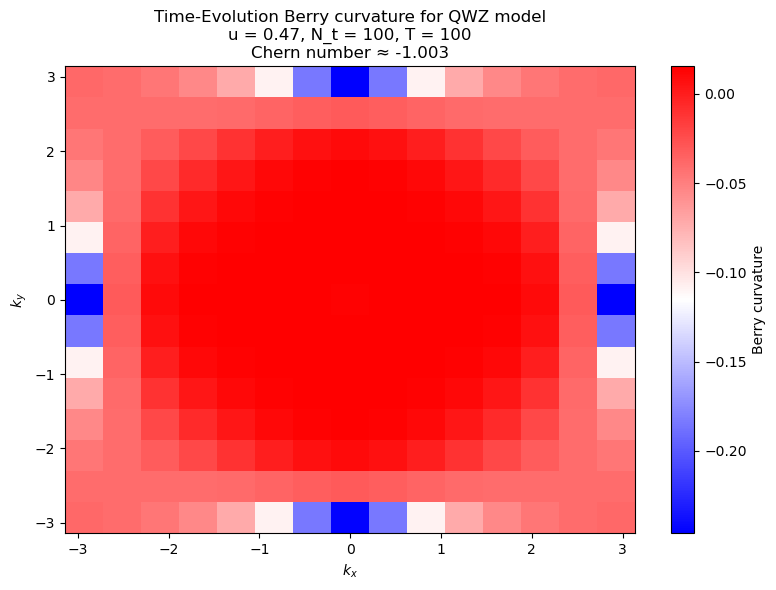

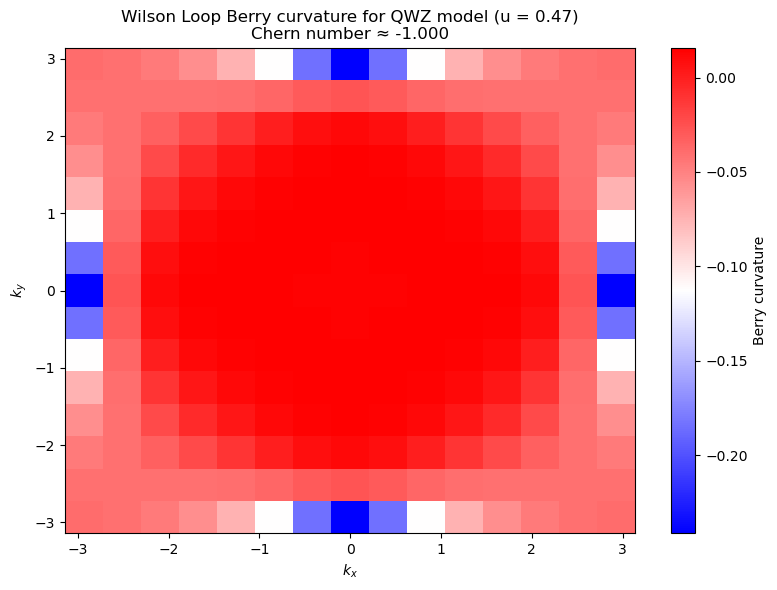

In [ ]:
def compute_TE_berry_curvature_grid(u, N_k=101, N_t=100, T=100):
    kx_vals = np.linspace(-np.pi, np.pi, N_k+1)
    ky_vals = np.linspace(-np.pi, np.pi, N_k+1)
    dk = kx_vals[1] - kx_vals[0]
    curvature = np.zeros((N_k, N_k))
    for i in range(N_k):
        for j in range(N_k):
            print(f'Evaluating k value {i*N_k + j + 1} out of {N_k**2}...' + 10*' ', end='\r')
            k = np.array([kx_vals[i], ky_vals[j]])
            v0 = gs_qwz(*k, u)
            U_1 = U_loop_QWZ(k0=k, dk=dk, N=N_t, u=u, T=T, reverse=False)
            U_2 = U_loop_QWZ(k0=k, dk=dk, N=N_t, u=u, T=T, reverse=True)
            U_tot = U_2 @ U_1
            E = np.vdot(v0, U_tot @ v0)
            curvature[i, j] = np.angle(E) / 2

    chern = np.sum(curvature) / (2 * np.pi)

    # Grid for plotting
    KX, KY = np.meshgrid(kx_vals[:-1], ky_vals[:-1]) + dk/2
    return KX, KY, curvature, chern


# Compute and plot
u = 0.47  # Should be in topological phase
N_k = 15
N_t = 100
T = 100
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

# Plot exact result at same resolution for comparison
KX, KY, F, chern = compute_berry_curvature_grid(u, N=N_k)
plot_curvature(KX, KY, F, chern, u=u, method='wilson')

Generally very good, though small error on the Chern number calculation. Varying N_t and T for illustrative purposes:

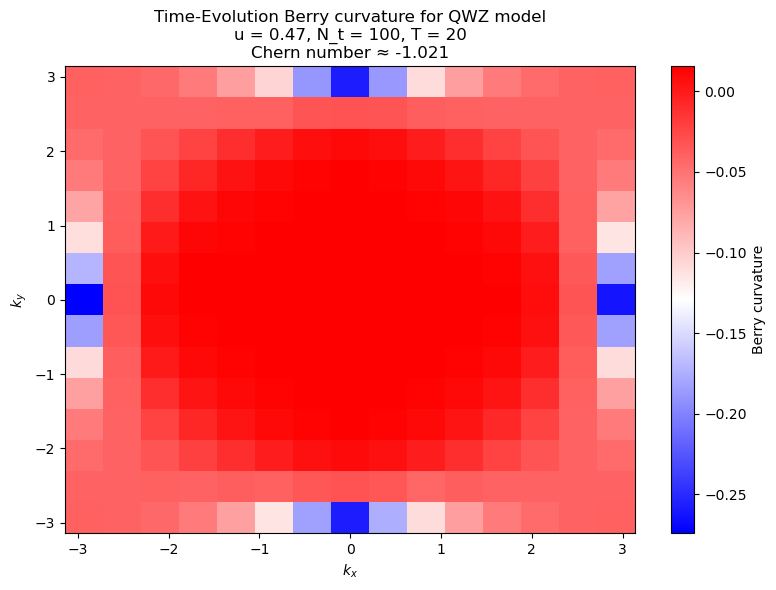

In [461]:
N_t = 100
T = 20
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

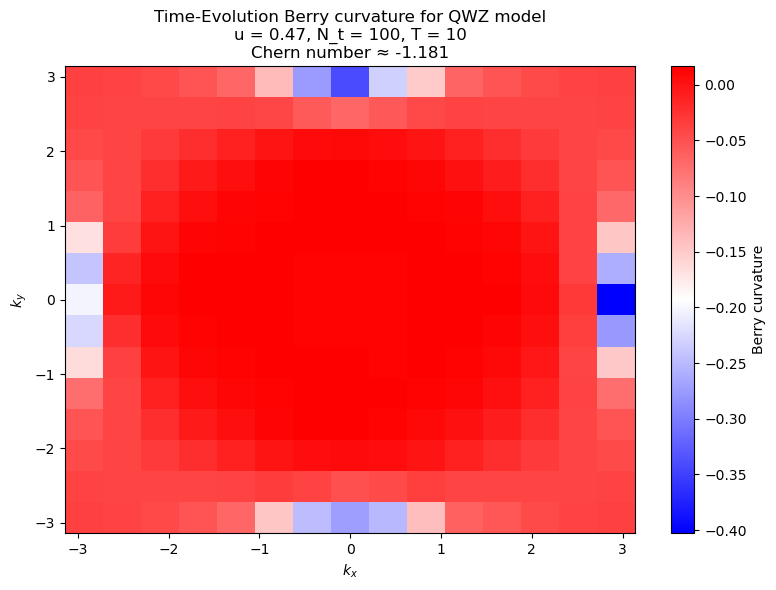

In [459]:
N_t = 100
T = 10
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

Assuming perfect calculations, $T$ should not affect accuracy - the way we've defined the path, the step in $k$-space $dk=\Delta k / N_t$ doesn't depend on $T$. (As opposed to defining a 'velocity' in $k$-space of $4 \Delta k / T$ and then sampling along the trajectory). Adiabaticity simply requires that $dk$ is sufficiently small, so we can break the propagator up into a product of steps with constant Hamiltonian; it doesn't care how long we stay evolving with each Hamiltonian. This is demonstrated above; reducing $T$ from 100 down to 20 hardly affects $C$. However, reducing $T$ further does degrade the accuracy. I think this is because now $dt = T/4N_t$ is too small, so the phase acquired on each time-evolution is small and susceptible to numerical noise/errors/imprecisions, especially when all of the $4N_t$ $U$-matrices are multiplied together. So, it makes sense to keep $T\sim N_t$ in future.

Varying $N_t$ at constant $T$, for completeness:

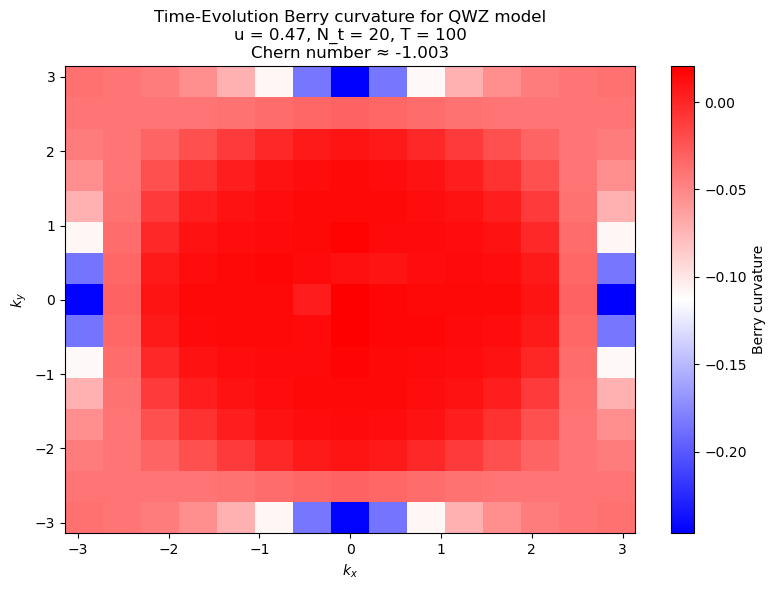

In [465]:
N_t = 20
T = 100
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

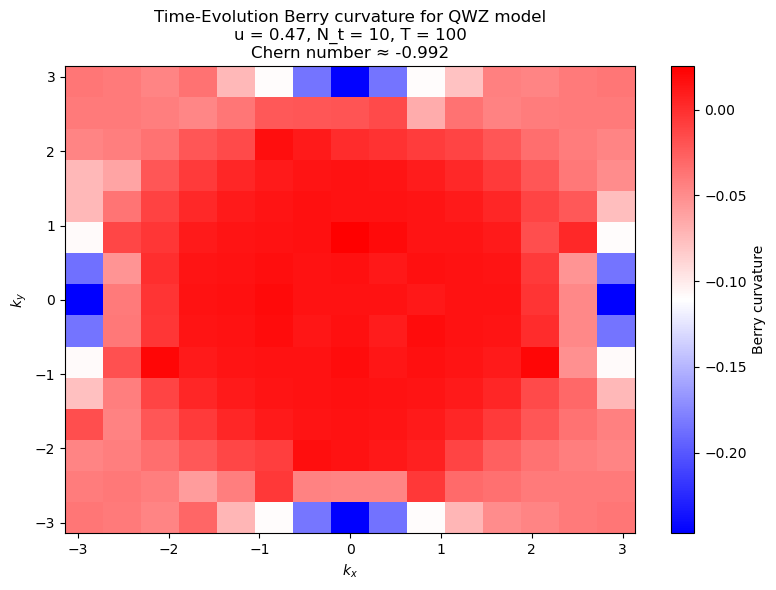

In [464]:
N_t = 10
T = 100
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

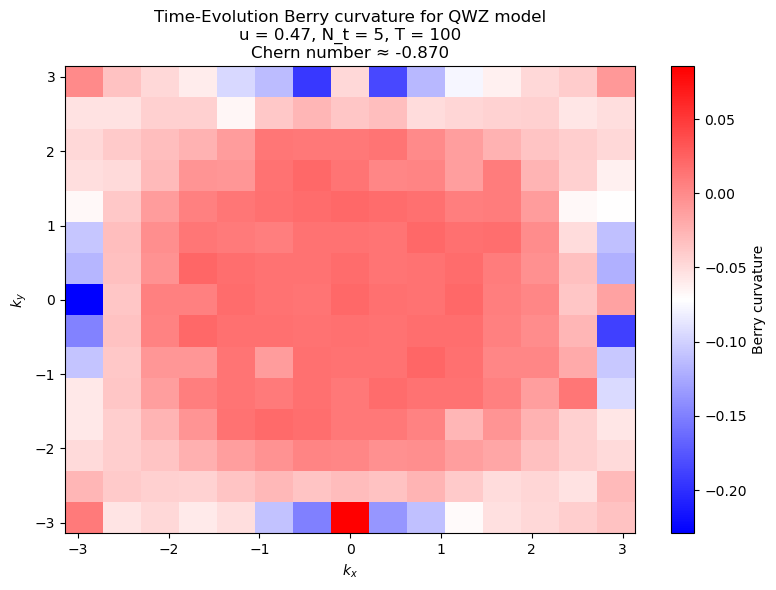

In [466]:
N_t = 5
T = 100
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

Still get good accuracy down to $N_t=10$ with $T=100$, and at greatly improved computational speed, so will stick with these values in future.

For smaller $N_t$, we are breaking the adiabaticity assumption, which means there is some contribution to the curvature from the higher band. This has opposite Chern number, which explains why the magnitude of the calculated value is reduced in this case. For larger $N_t$, the small errors in $C$ are just due to floating-point errors or similar, so they are 'allowed' to be wrong in either direction.

## Ground State Preparation

Before implementing the full quantum algorithm to calculate the Berry flux over the BZ, there is a final piece of the jigsaw: how to prepare the qubit of the system in the ground state. Our previous implementation of the phase estimation algorithm simply defined a diagonal $U$ gate which applied a phase $\theta$ to the qubit in state $|0\rangle$. Now, we want to act on the qubit to rotate it into the ground state $|\psi_0\rangle$ of the Hamiltonian $H(\mathbf{k})$, and then act on $|\psi_0\rangle$ with the operator $U_\text{loop}$:

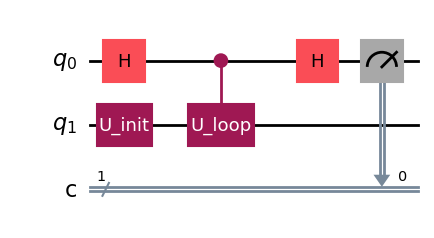

In [329]:
U = np.eye(2)
qc = C_circuit(U, U_init=U) # NB these U matrices are just placeholders to generate the diagram
qc.draw('mpl')

This can be achieved using the projection operator to the ground state:
$$
P = |\psi_0\rangle\langle\psi_0|=\frac{1}{2}(\mathbb{1} - \hat{\mathbf{d}}\cdot\boldsymbol{\sigma})
$$
Acting with $P$ on any state $|\psi\rangle$ will return a state proportional to $|\psi_0\rangle$. The state will not necessarily be normalised, but we only care about the phase acquired by the state due to $U_\text{loop}$, so this does not matter. Implementing and testing the projection operator in python:

In [338]:
def P_qwz(k, u):
    H = hamiltonian_qwz(*k, u)
    d = d_QWZ(k, u)
    return 0.5 * (np.eye(2) - H / np.linalg.norm(d))

# Start from |0> state:
psi = np.array([1, 0])

# Generate random k-point
k = np.random.rand(2) * 2 * np.pi - np.pi
r = 4
print(f'k = {np.round(k,r)}')
u = 0.47
psi0_exact = gs_qwz(*k, u, gauge=True)
print(f'Exact GS = {np.round(psi0_exact,r)}')

P = P_qwz(k, u)
psi0_proj = P @ psi
print(f'Projected state = {np.round(psi0_proj,r)}')
psi0_proj_norm = psi0_proj / np.linalg.norm(psi0_proj)
psi0_proj_norm *= np.exp(-1j*np.angle(psi0_proj_norm[0]))
print(f'Normalised and gauge-fixed projected state = {np.round(psi0_proj_norm,r)}')



k = [-2.0144 -0.9391]
Exact GS = [0.5185+0.j     0.6376+0.5697j]
Projected state = [0.2689+0.j     0.3306+0.2954j]
Normalised and gauge-fixed projected state = [0.5185+0.j     0.6376+0.5697j]


See exact agreement between states obtained via diagonalization, and via projection. However, the projection operator is not unitary, and therefore cannot be implemented as a gate in the circuit. Instead, we simply define a unitary initialisation gate $U_\text{init}$ by diagonalising to find the eigenvector components:
$$
U_\text{init}|0\rangle = |\psi_0\rangle
$$

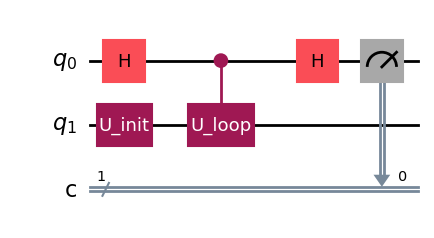

In [424]:
def U_init(k, u):
    u = gs_qwz(*k, u)
    U_init = np.array([[u[0], -np.conj(u[1])],
                       [u[1], np.conj(u[0])]])
    return U_init

# Test that circuit constructs correctly for random point k
k = np.random.rand(2) * 2 * np.pi - np.pi
dk = 0.02
u = 0.47
U_i = U_init(k, u)
U_1 = U_loop_QWZ(k0=k, dk=dk, N=10, u=u, T=1, reverse=False)
U_2 = U_loop_QWZ(k0=k, dk=dk, N=10, u=u, T=1, reverse=True)
U_tot = U_2 @ U_1
# print(U_tot)
# print(np.conj(U_tot.T) @ U_tot)
qc = C_circuit(U=U_tot, U_init=U_i)
qc.draw('mpl')

Of course, this method of ground state preparation is very artificial; if we know the eigenstate already, then we may as well calculate the Berry flux from the (classical) Wilson loop method. However, this quantum algorithm is designed with interacting systems in mind, where we cannot analytically (or even classically numerically) solve for the ground state. Then, $U_{\text{init}}$ may be replaced by a variational quantum ground-state preparation procedure, and then the phase acquired by this (unknown) ground state upon action by $U_\text{loop}$ can be calculated.

## Quantum Phase Estimation for Berry Flux

Implement code which runs over $k$ in the BZ, at each point calculating the $U$ matrix corresponding to time-evolution around the plaquette of side-length $dk$, including the reverse loop as well. The phase associated with this is then estimated using the Hadamard test, and the Berry phase calculated as half this. The Berry flux is then plotted over the BZ.

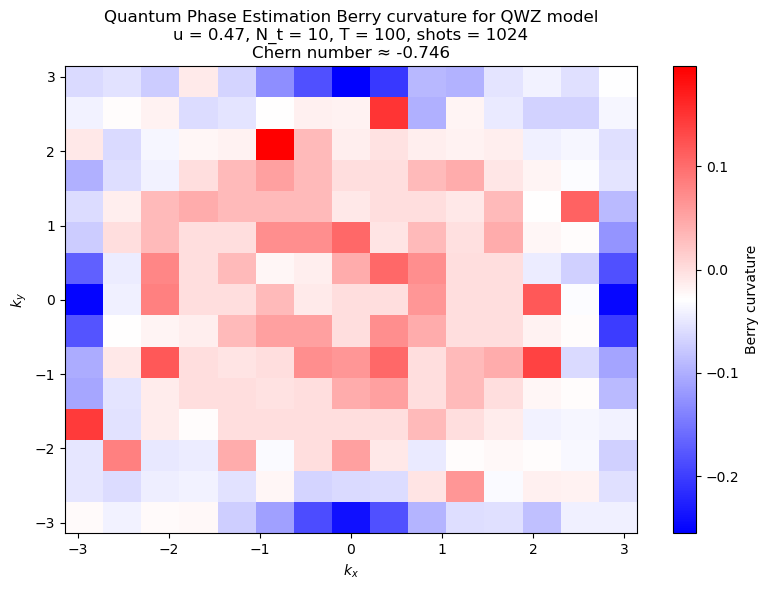

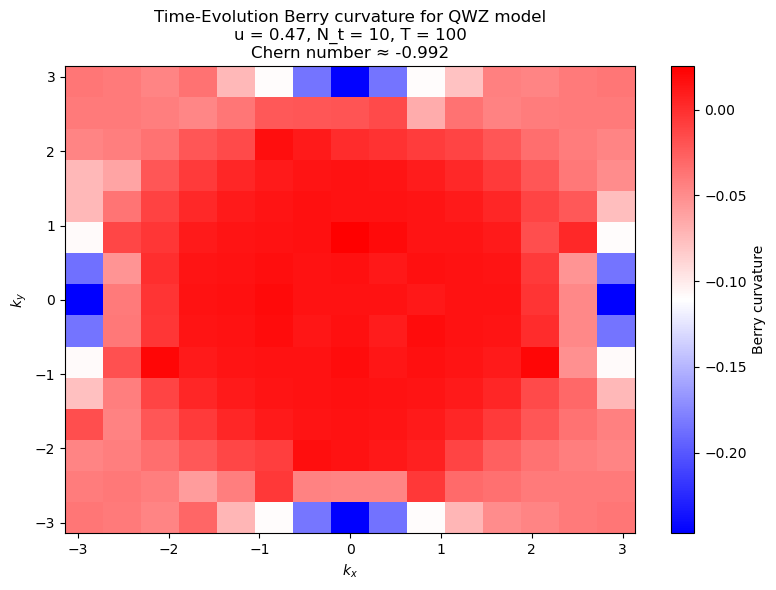

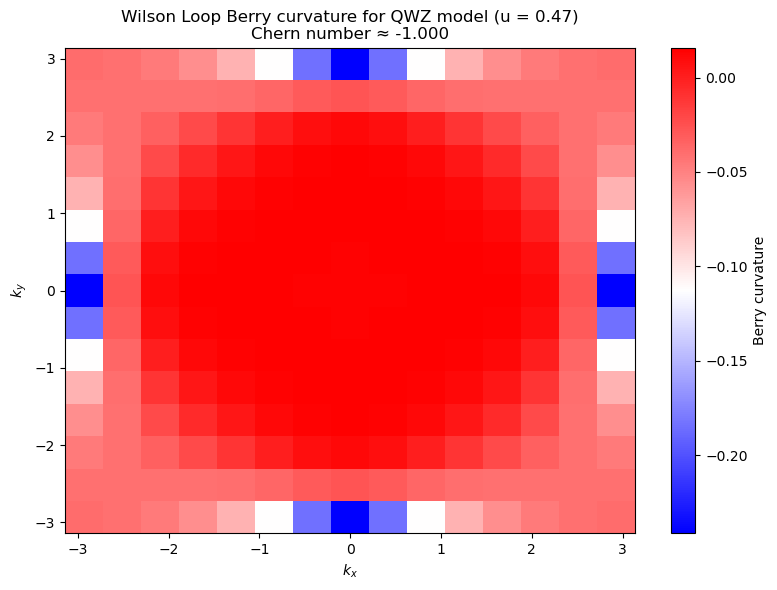

In [467]:
def compute_QPE_berry_curvature_grid(u, N_k=15, N_t=10, T=1, backend=AerSimulator(), shots=1024):
    kx_vals = np.linspace(-np.pi, np.pi, N_k+1)
    ky_vals = np.linspace(-np.pi, np.pi, N_k+1)
    dk = kx_vals[1] - kx_vals[0]
    curvature = np.zeros((N_k, N_k))
    for i in range(N_k):
        for j in range(N_k):
            print(f'Evaluating k point {i*N_k + j + 1} out of {N_k**2}...' + 10*' ', end='\r')
            k0 = np.array([kx_vals[i], ky_vals[j]])
            U_i = U_init(k0, u)
            # print(U_i)
            # print(np.conj(U_i).T @ U_i)
            U1 = U_loop_QWZ(k0=k0, dk=dk, N=N_t, u=u, T=T, reverse=False)
            U2 = U_loop_QWZ(k0=k0, dk=dk, N=N_t, u=u, T=T, reverse=True)
            U_tot = U2 @ U1
            curvature[i, j] = estimate_theta(U=U_tot, U_init=U_i, backend=backend) / 2
            # print('done')

    chern = np.sum(curvature) / (2 * np.pi)

    # Grid for plotting
    KX, KY = np.meshgrid(kx_vals[:-1], ky_vals[:-1]) + dk/2
    return KX, KY, curvature, chern

# Compute and plot
u = 0.47  # Should be in topological phase
N_k = 15
N_t = 10
T = 100
backend = AerSimulator()
shots = 1024
KX, KY, F, chern = compute_QPE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T, backend=backend, shots=shots)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, shots=shots, method='QPE')

# Calculate and plot using alternative methods for comparison
# Time-Evolution:
KX, KY, F, chern = compute_TE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, method='TE')

# Wilson Loop:
KX, KY, F, chern = compute_berry_curvature_grid(u, N=N_k)
plot_curvature(KX, KY, F, chern, u=u, method='wilson')


Evident from this that most of the error/uncertainty is in the phase-estimation step, not the accuracy of the time-evolution. To fix this, go to a greater number of shots (of course, at the cost of greater computation time):

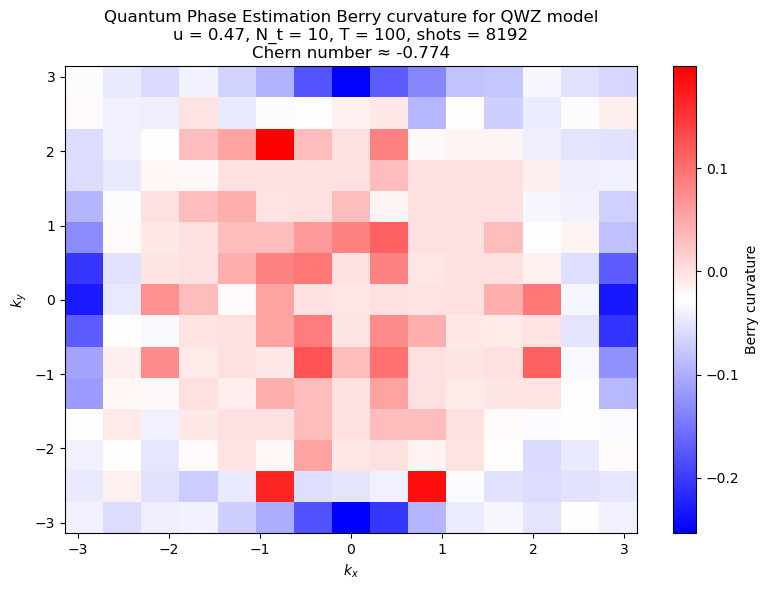

In [468]:
shots = 8192
KX, KY, F, chern = compute_QPE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T, backend=backend, shots=shots)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, shots=shots, method='QPE')

Slightly better, but not a great deal. Will stop trying to optimise this for now, and just move onto implementing the algorithm on actual quantum hardware.

## Quantum Hardware Implementation

### Noisy Quantum Simulator

First, implement on a noisy quantum simulator instead of the idealised simulator used previously. For interest, plot the transpiled circuit here to see if/how it differs:

Original Circuit:


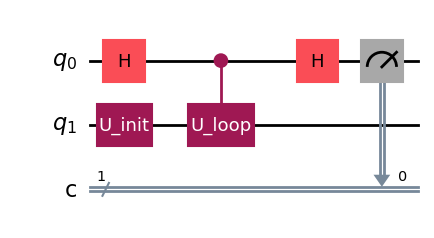

Transpiled Circuit:


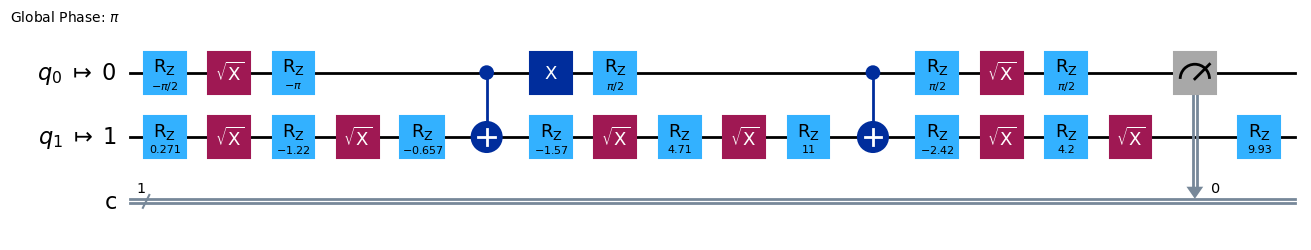

In [472]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
k = np.random.rand(2) * 2 * np.pi - np.pi
dk = 0.02
u = 0.47
U_i = U_init(k, u)
U_1 = U_loop_QWZ(k0=k, dk=dk, N=10, u=u, T=1, reverse=False)
U_2 = U_loop_QWZ(k0=k, dk=dk, N=10, u=u, T=1, reverse=True)
U_tot = U_2 @ U_1
qc = C_circuit(U=U_tot, U_init=U_i)
print('Original Circuit:')
orig = qc.draw('mpl')
display(orig)
transpiled_qc = transpile(qc, backend=FakeManilaV2(), optimization_level=1)
print('Transpiled Circuit:')
transpiled = transpiled_qc.draw('mpl')
display(transpiled)

Can see that this backend has $R_z$, $\sqrt{X}$, $\text{CNOT}$ and $X$ as its fundamental gates. Now, run the full calculation on this noisy simulator:

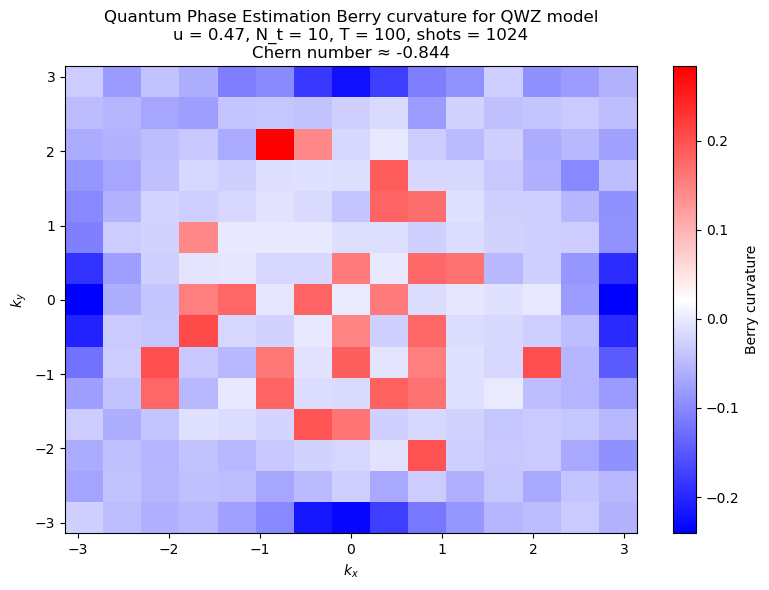

In [ ]:
u = 0.47
N_k = 15
N_t = 10
T = 100
backend = FakeManilaV2()
shots = 1024
KX, KY, F, chern = compute_QPE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T, backend=backend, shots=shots)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, shots=shots, method='QPE')

Not bad - in fact does better than the idealised simulator! Somehow the noise is helpful. Comparing the colorbar scale and plot to earlier, seems to 'polarise' the results a lot more - instead of accurately resolving the fairly low fluxes, it makes some of them more negative, and others more positive.

### Actual Quantum Hardware

Now want to use the actual quantum computers to run the same calculation. First, need to get this all set up and test that I can run simple calculations on it, then will load the actual calculation.

In [ ]:
token = ''  # Copy own token here

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
  token=token, 
  instance="IBMQ", # Optionally specify the instance to use.
  set_as_default=True, # Optionally set as default credentials.
  overwrite=True,
)

service = QiskitRuntimeService()

In [479]:
service = QiskitRuntimeService()
backends = service.backends()

# Print names and number of qubits for each backend
print('All devices:')
for backend in backends:
    print(f"{backend.name:20} - {backend.num_qubits} qubits - {'Simulator' if backend.simulator else 'Real Quantum Device'}")

devices = service.backends(simulator=False, min_num_qubits=5, operational=True)
least_busy = sorted(devices, key=lambda b: b.status().pending_jobs)[0]

print(f"\nLeast busy device: {least_busy.name} - {least_busy.num_qubits} qubits - {least_busy.status().pending_jobs} pending jobs")

All devices:
ibm_brisbane         - 127 qubits - Real Quantum Device
ibm_sherbrooke       - 127 qubits - Real Quantum Device
ibm_torino           - 133 qubits - Real Quantum Device

Least busy device: ibm_sherbrooke - 127 qubits - 193 pending jobs


Testing the functionality of the devices by running a simple simulation:

Least busy device: ibm_sherbrooke - 127 qubits - 199 pending jobs
Original circuit:


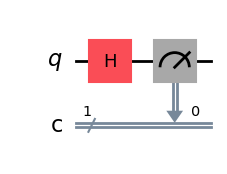


 Transpiled circuit:


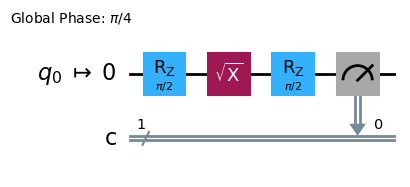

[2025-06-30 12:05:53.401721] Job status: QUEUED
[2025-06-30 15:59:20.925067] Status: QUEUED          


NameError: name 'plot_histogram' is not defined

In [ ]:
import time
import datetime
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
print(f'Least busy device: {backend.name} - {backend.num_qubits} qubits - {backend.status().pending_jobs} pending jobs')

qc = QuantumCircuit(1, 1)   # initialise 1 qubit, 1 (classical) bit
qc.h(0)                     # apply Hadamard |0> 
qc.measure(0, 0)            # measure qubit label 0 and store it bit label 0


##-- View the circuit --##
print("Original circuit:")
fig = qc.draw('mpl')
display(fig)


####-- Transpile the circuit to match machine gates --####
transpiled_qc = transpile(qc, backend=backend, optimization_level=1)

##-- View the transpiled circuit -- ##
print("\n Transpiled circuit:")
fig2 = transpiled_qc.draw('mpl')
display(fig2)


####-- Run the transpiled circuit using the backend picked earlier --####
sampler = Sampler(backend)
job = sampler.run([transpiled_qc],shots=1024)
# def print_job_attributes(job):
#     attrs = [attr for attr in dir(job) if not attr.startswith('_')]

#     for attr in attrs:
#         try:
#             value = getattr(job, attr)
#             if not callable(value):
#                 print(f"{attr:25}: {value}")
#         except Exception as e:
#             print(f"{attr:25}: <Error accessing attribute: {e}>")

# # Usage:
# print_job_attributes(job)

print(f"[{datetime.datetime.now()}] Job status: INITIALISED", end='\r')
old_status = ''
while job.status() not in ["DONE", "CANCELLED", "ERROR"]:
    if job.status() != old_status:
        print(f"\n[{datetime.datetime.now()}] Job status: {job.status()}" + 10*' ', end='\r')
        old_status = job.status()
    else:
        print(f"[{datetime.datetime.now()}] Job status: {job.status()}" + 10*' ', end='\r')
    time.sleep(5)
# while job.status() not in ["DONE", "CANCELLED", "ERROR"]:
#     print(f"Status: {job.status()}")
#     if job.queue_position() is not None:
#         print(f"Queue position: {job.queue_position()}")
#     time.sleep(5)
result = job.result()

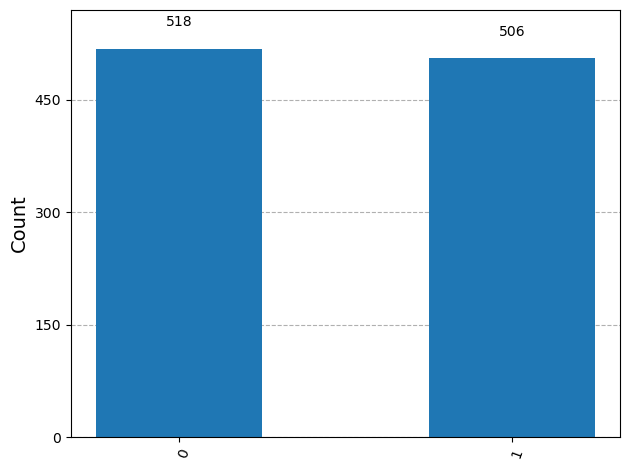

In [488]:
from qiskit.visualization import plot_histogram
counts = result[0].data.c.get_counts()
plot_histogram(counts)

Now, run actual computation of Berry phase:

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
print(f'Least busy device: {backend.name} - {backend.num_qubits} qubits - {backend.status().pending_jobs} pending jobs')
u = 0.47
N_k = 15
N_t = 10
T = 100
shots = 1024
KX, KY, F, chern = compute_QPE_berry_curvature_grid(u, N_k=N_k, N_t=N_t, T=T, backend=backend, shots=shots)
plot_curvature(KX, KY, F, chern, u=u, N_t=N_t, T=T, shots=shots, method='QPE')